In [1]:
from pathlib import Path
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np

In [2]:
path_felix = r"C:\Users\richt\Documents\ASME_data\train\Fusion360GalleryDataset_23hackathon_train"
base_path = path_felix

In [3]:
def extract_bodies(json_data):
    bodies_data = json_data.get('bodies', {})
    
    rows = []
    for body_id, body in bodies_data.items():
        physical_properties = body.get('physical_properties', {})
        
        # Extract volume and area from the physical_properties
        volume = physical_properties.get('volume', None)
        area = physical_properties.get('area', None)

        row = {
            'body_id': body_id,
            'name': body.get('name', None),
            'volume': volume,
            'area': area,
            'material_category': body.get('material_category', None),
            # Add any other attributes you want from the body object here.
        }
        rows.append(row)
    
    return rows


In [4]:
def extract_properties(json_data):
    properties = json_data.get('properties', {})

    # Extract features
    name = properties.get("name", None)
    vertex_count = properties.get("vertex_count", None)
    edge_count = properties.get("edge_count", None)
    face_count = properties.get("face_count", None)
    loop_count = properties.get("loop_count", None)
    shell_count = properties.get("shell_count", None)
    body_count = properties.get("body_count", None)
    area = properties.get("area", None)
    volume = properties.get("volume", None)
    design_type = properties.get("design_type", None)
    likes_count = properties.get("likes_count", None)
    comments_count = properties.get("comments_count", None)
    views_count = properties.get("views_count", None)
    categories = properties.get("categories", [])
    industries = properties.get("industries", [])

    return [name, vertex_count, edge_count, face_count, loop_count, shell_count, body_count, area, volume, design_type, likes_count, comments_count, views_count, categories, industries]

In [5]:
def extract_occurrences(json_data):
    occurrences_data = json_data.get('occurrences', {})
    
    rows = []
    for occurrence_id, occurrence in occurrences_data.items():
        bodies = occurrence.get('bodies', {})
        for body_id in bodies:
            row = {
                'occurrence_id': occurrence_id,
                'name': occurrence.get('name', None),
                'component': occurrence.get('component', None),
                'body_id': body_id
            }
            rows.append(row)
    
    return rows

In [6]:
def extract_components(json_data):
    components_data = json_data.get('components', {})
    
    rows = []
    for component_id, component in components_data.items():
        bodies = component.get('bodies', [])
        for body_id in bodies:
            row = {
                'component_id': component_id,
                'name': component.get('name', None),
                'body_id': body_id
            }
            rows.append(row)
    
    return rows

In [7]:
all_data = []

for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    if os.path.isdir(folder_path):
        json_file = os.path.join(folder_path, 'assembly.json')
        if os.path.exists(json_file):
            with open(json_file, 'r') as f:
                json_data = json.load(f)
                data_for_folder = extract_bodies(json_data)
                for row in data_for_folder:
                    row['assembly_id'] = folder
                all_data.extend(data_for_folder)

df_bodies = pd.DataFrame(all_data)

# Rearrange columns
df_bodies = df_bodies[['body_id', 'assembly_id', 'name', 'volume', 'area','material_category']]

In [8]:
all_categories = {}
all_industries = set()
data_properties = []  # Initialization here

# Single loop to gather information and extract data
for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    if os.path.isdir(folder_path):
        json_file = os.path.join(folder_path, 'assembly.json')
        if os.path.exists(json_file):
            with open(json_file, 'r') as f:
                json_data = json.load(f)
                _, _, _, _, _, _, _, _, _, _, _, _, _, categories, industries = extract_properties(json_data)
                
                for category in categories:
                    all_categories[category] = all_categories.get(category, 0) + 1
                    
                all_industries.update(industries)

# Keep top 'n' categories based on their frequency (say, n=10)
n = 10
top_categories = [cat[0] for cat in sorted(all_categories.items(), key=lambda x: x[1], reverse=True)[:n]]

# Creating dataframe columns
columns = ['assembly_id', 'name', 'vertex_count', 'edge_count', 'face_count', 'loop_count', 'shell_count', 'body_count', 'area', 'volume', 'design_type', 'likes_count', 'comments_count', 'views_count']
columns.extend([f'category_{cat}' for cat in top_categories])
columns.extend([f'industry_{industry}' for industry in all_industries])

# Populate dataframe
for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    if os.path.isdir(folder_path):
        json_file = os.path.join(folder_path, 'assembly.json')
        if os.path.exists(json_file):
            with open(json_file, 'r') as f:
                json_data = json.load(f)
                row_data = extract_properties(json_data)

                row = row_data[:13]

                categories = row_data[13]
                industries = row_data[14]

                for category in top_categories:
                    row.append(1 if category in categories else 0)

                for industry in all_industries:
                    row.append(1 if industry in industries else 0)

                data_properties.append([folder] + row)

df_properties = pd.DataFrame(data_properties, columns=columns)


In [9]:
all_data = []

for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    if os.path.isdir(folder_path):
        json_file = os.path.join(folder_path, 'assembly.json')
        if os.path.exists(json_file):
            with open(json_file, 'r') as f:
                json_data = json.load(f)
                data_for_folder = extract_occurrences(json_data)
                for row in data_for_folder:
                    row['assembly_id'] = folder
                all_data.extend(data_for_folder)

df_occurrences = pd.DataFrame(all_data)

In [10]:
all_data = []

for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    if os.path.isdir(folder_path):
        json_file = os.path.join(folder_path, 'assembly.json')
        if os.path.exists(json_file):
            with open(json_file, 'r') as f:
                json_data = json.load(f)
                data_for_folder = extract_components(json_data)
                for row in data_for_folder:
                    row['assembly_id'] = folder
                all_data.extend(data_for_folder)

df_components = pd.DataFrame(all_data)

In [11]:
df_bodies.head()

,body_id,assembly_id,name,volume,area,material_category
0,f130d4f0-054c-11ec-a094-0a2b8709b52f,100029_94515530,Body1,0.064315,1.892846,Plastic
1,f1314a74-054c-11ec-ac03-0a2b8709b52f,100029_94515530,Body4,0.007196,0.659531,Metal_Ferrous_Steel
2,f131bfb6-054c-11ec-9eb4-0a2b8709b52f,100029_94515530,Body5,0.007167,0.657318,Metal_Non-Ferrous
3,f13234e8-054c-11ec-8b13-0a2b8709b52f,100029_94515530,Body6,0.064315,1.892846,Other
4,f13282ee-054c-11ec-aa03-0a2b8709b52f,100029_94515530,Body7,0.064315,1.892846,Plastic


In [12]:
df_properties.head()

,assembly_id,name,vertex_count,edge_count,face_count,loop_count,shell_count,body_count,area,volume,...,category_Furniture + Household,category_Tools,category_Automotive,category_Design,category_Toys,industry_Media & Entertainment,industry_Civil Infrastructure,industry_Product Design & Manufacturing,industry_Other Industries,"industry_Architecture, Engineering & Construction"
0,100029_94515530,Untitled,350,507,211,253,6,6,7.652705,0.214475,...,0,0,0,0,0,0,0,1,0,0
1,100106_7f144e5b,Untitled,298,447,166,185,2,2,294.718856,42.378176,...,0,0,0,0,0,0,0,1,0,0
2,100112_bc0a563a,Untitled,1031,1500,678,837,64,64,23238.618896,6971.244191,...,0,0,1,0,0,0,0,1,0,1
3,100126_e58fbfba,Untitled,43,61,32,43,3,3,156.813970,121.481504,...,0,0,0,0,0,0,0,1,0,0
4,100138_119e1068,Untitled,50,78,29,30,1,1,14.929349,1.795948,...,0,0,0,0,1,0,0,1,0,0


In [13]:
df_occurrences.head(100)

,occurrence_id,name,component,body_id,assembly_id
0,0b4c439a-0529-11ec-9ff8-020dc2b44123,Base:1,0b4a6edc-0529-11ec-99fe-020dc2b44123,0b41206c-0529-11ec-87d0-020dc2b44123,100221_4d7b66c4
1,0b4c91be-0529-11ec-9016-020dc2b44123,Lid:1,0b4a6edd-0529-11ec-999a-020dc2b44123,0b419630-0529-11ec-a6a6-020dc2b44123,100221_4d7b66c4
2,0b4d06e8-0529-11ec-9344-020dc2b44123,Hinge:1,0b4a4824-0529-11ec-9f70-020dc2b44123,0b40d208-0529-11ec-b1f1-020dc2b44123,100221_4d7b66c4
3,0b4dca30-0529-11ec-9bfd-020dc2b44123,Component5:1,0b4ae409-0529-11ec-b146-020dc2b44123,0b44546c-0529-11ec-b6a5-020dc2b44123,100221_4d7b66c4
4,0b4e666c-0529-11ec-bbbb-020dc2b44123,Component6:1,0b4a95ee-0529-11ec-bf21-020dc2b44123,0b420ad4-0529-11ec-aac9-020dc2b44123,100221_4d7b66c4
...,...,...,...,...,...
95,509dc7e2-05a1-11ec-9b54-0621f375c677,Lock Nut v1:1,508f7001-05a1-11ec-b278-0621f375c677,5023dd4a-05a1-11ec-b963-0621f375c677,100622_1c7038f5
96,509e8b30-05a1-11ec-aea3-0621f375c677,91292A141:1,508d9b41-05a1-11ec-8dcc-0621f375c677,4fab2a58-05a1-11ec-bbe8-0621f375c677,100622_1c7038f5
97,509fc3b4-05a1-11ec-beb1-0621f375c677,Front Axle Support v1:1,508ed3ca-05a1-11ec-ae8c-0621f375c677,500642d2-05a1-11ec-9c8d-0621f375c677,100622_1c7038f5
98,50a5de30-05a1-11ec-bf75-0621f375c677,Deck v1:1,508e85a2-05a1-11ec-b495-0621f375c677,50024b3e-05a1-11ec-8c60-0621f375c677,100622_1c7038f5


In [14]:
df_components.head(100)

,component_id,name,body_id,assembly_id
0,f1331f28-054c-11ec-b126-0a2b8709b52f,root,f130d4f0-054c-11ec-a094-0a2b8709b52f,100029_94515530
1,f1331f28-054c-11ec-b126-0a2b8709b52f,root,f1314a74-054c-11ec-ac03-0a2b8709b52f,100029_94515530
2,f1331f28-054c-11ec-b126-0a2b8709b52f,root,f131bfb6-054c-11ec-9eb4-0a2b8709b52f,100029_94515530
3,f1331f28-054c-11ec-b126-0a2b8709b52f,root,f13234e8-054c-11ec-8b13-0a2b8709b52f,100029_94515530
4,f1331f28-054c-11ec-b126-0a2b8709b52f,root,f13282ee-054c-11ec-aa03-0a2b8709b52f,100029_94515530
...,...,...,...,...
95,0b4a95ef-0529-11ec-8ac4-020dc2b44123,01-1785,0b427fe4-0529-11ec-ba06-020dc2b44123,100221_4d7b66c4
96,0b4a95f0-0529-11ec-a433-020dc2b44123,1785B,0b42a6e6-0529-11ec-8f25-020dc2b44123,100221_4d7b66c4
97,0b4abcf6-0529-11ec-afe8-020dc2b44123,1785A,0b431c1c-0529-11ec-b773-020dc2b44123,100221_4d7b66c4
98,0b4ae409-0529-11ec-b146-020dc2b44123,Component5,0b44546c-0529-11ec-b6a5-020dc2b44123,100221_4d7b66c4


In [15]:
# Prefix only if not already prefixed
if not df_properties.columns[0].startswith('properties_'):
    df_properties = df_properties.add_prefix('properties_')

# However, since 'assembly_id' is our merging key, we should exclude it from renaming
df_properties = df_properties.rename(columns={'properties_assembly_id': 'assembly_id'})

df_main = pd.merge(df_bodies, df_properties, on='assembly_id', how='inner')

In [16]:
df_main.head()

,body_id,assembly_id,name,volume,area,material_category,properties_name,properties_vertex_count,properties_edge_count,properties_face_count,...,properties_category_Furniture + Household,properties_category_Tools,properties_category_Automotive,properties_category_Design,properties_category_Toys,properties_industry_Media & Entertainment,properties_industry_Civil Infrastructure,properties_industry_Product Design & Manufacturing,properties_industry_Other Industries,"properties_industry_Architecture, Engineering & Construction"
0,f130d4f0-054c-11ec-a094-0a2b8709b52f,100029_94515530,Body1,0.064315,1.892846,Plastic,Untitled,350,507,211,...,0,0,0,0,0,0,0,1,0,0
1,f1314a74-054c-11ec-ac03-0a2b8709b52f,100029_94515530,Body4,0.007196,0.659531,Metal_Ferrous_Steel,Untitled,350,507,211,...,0,0,0,0,0,0,0,1,0,0
2,f131bfb6-054c-11ec-9eb4-0a2b8709b52f,100029_94515530,Body5,0.007167,0.657318,Metal_Non-Ferrous,Untitled,350,507,211,...,0,0,0,0,0,0,0,1,0,0
3,f13234e8-054c-11ec-8b13-0a2b8709b52f,100029_94515530,Body6,0.064315,1.892846,Other,Untitled,350,507,211,...,0,0,0,0,0,0,0,1,0,0
4,f13282ee-054c-11ec-aa03-0a2b8709b52f,100029_94515530,Body7,0.064315,1.892846,Plastic,Untitled,350,507,211,...,0,0,0,0,0,0,0,1,0,0


In [17]:
# Prefix only if not already prefixed
if not df_occurrences.columns[0].startswith('occurrences_'):
    df_occurrences = df_occurrences.add_prefix('occurrences_')

# Rename the columns that are used for merging to their original names
df_occurrences = df_occurrences.rename(columns={'occurrences_body_id': 'body_id', 'occurrences_assembly_id': 'assembly_id'})

df_main = pd.merge(df_main, df_occurrences, on=['body_id', 'assembly_id'], how='inner')
df_main = df_main.drop(columns=["occurrences_occurrence_id", "occurrences_component"])

In [18]:
df_main.head()

,body_id,assembly_id,name,volume,area,material_category,properties_name,properties_vertex_count,properties_edge_count,properties_face_count,...,properties_category_Tools,properties_category_Automotive,properties_category_Design,properties_category_Toys,properties_industry_Media & Entertainment,properties_industry_Civil Infrastructure,properties_industry_Product Design & Manufacturing,properties_industry_Other Industries,"properties_industry_Architecture, Engineering & Construction",occurrences_name
0,0b40d208-0529-11ec-b1f1-020dc2b44123,100221_4d7b66c4,Body4,1.183269,13.793986,Metal_Ferrous_Steel,Untitled,1065,1686,690,...,1,0,0,0,0,0,1,0,0,Hinge:1
1,0b41206c-0529-11ec-87d0-020dc2b44123,100221_4d7b66c4,Body1,188.236351,1194.122208,Plastic,Untitled,1065,1686,690,...,1,0,0,0,0,0,1,0,0,Base:1
2,0b419630-0529-11ec-a6a6-020dc2b44123,100221_4d7b66c4,Body1,112.561776,737.410188,Plastic,Untitled,1065,1686,690,...,1,0,0,0,0,0,1,0,0,Lid:1
3,0b420ad4-0529-11ec-aac9-020dc2b44123,100221_4d7b66c4,Body1,1.646435,41.360040,Plastic,Untitled,1065,1686,690,...,1,0,0,0,0,0,1,0,0,Component6:1
4,0b427fe4-0529-11ec-ba06-020dc2b44123,100221_4d7b66c4,Body1,0.094115,2.612833,Metal_Ferrous_Steel,Untitled,1065,1686,690,...,1,0,0,0,0,0,1,0,0,01-1785:1


In [19]:
# Prefix for df_components
if not df_components.columns[0].startswith('components_'):
    df_components = df_components.add_prefix('components_')

# Rename the columns used for merging to their original names
df_components = df_components.rename(columns={'components_body_id': 'body_id', 'components_assembly_id': 'assembly_id'})

# Merge with df_main
df_main = pd.merge(df_main, df_components[['body_id', 'assembly_id', 'components_name']], on=['body_id', 'assembly_id'], how='left')

In [21]:
pd.set_option('display.max_columns', None)
df_main.tail(100)

,body_id,assembly_id,name,volume,area,material_category,properties_name,properties_vertex_count,properties_edge_count,properties_face_count,properties_loop_count,properties_shell_count,properties_body_count,properties_area,properties_volume,properties_design_type,properties_likes_count,properties_comments_count,properties_views_count,properties_category_Mechanical Engineering,properties_category_Product Design,properties_category_Miscellaneous,properties_category_Electronics,properties_category_Machine design,properties_category_Furniture + Household,properties_category_Tools,properties_category_Automotive,properties_category_Design,properties_category_Toys,properties_industry_Media & Entertainment,properties_industry_Civil Infrastructure,properties_industry_Product Design & Manufacturing,properties_industry_Other Industries,"properties_industry_Architecture, Engineering & Construction",occurrences_name,components_name
92840,c67b0c78-057a-11ec-8af1-0a8b801be05d,99636_73c43ebd,Body1,1695.317764,3503.039398,Plastic,Untitled,1003,1596,765,939,36,36,20988.732785,17735.548425,ParametricDesignType,1,1,235,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,kolo:1,kolo
92841,c6851e80-057a-11ec-8179-0a8b801be05d,99636_73c43ebd,Body1,16.511124,38.992308,Plastic,Untitled,1003,1596,765,939,36,36,20988.732785,17735.548425,ParametricDesignType,1,1,235,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,Součást3:1,Součást3
92842,c6851e80-057a-11ec-8179-0a8b801be05d,99636_73c43ebd,Body1,16.511124,38.992308,Plastic,Untitled,1003,1596,765,939,36,36,20988.732785,17735.548425,ParametricDesignType,1,1,235,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,Součást3:1,Součást3
92843,c6851e80-057a-11ec-8179-0a8b801be05d,99636_73c43ebd,Body1,16.511124,38.992308,Plastic,Untitled,1003,1596,765,939,36,36,20988.732785,17735.548425,ParametricDesignType,1,1,235,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,Součást3:1,Součást3
92844,c6851e80-057a-11ec-8179-0a8b801be05d,99636_73c43ebd,Body1,16.511124,38.992308,Plastic,Untitled,1003,1596,765,939,36,36,20988.732785,17735.548425,ParametricDesignType,1,1,235,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,Součást3:1,Součást3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92935,f95af41c-0613-11ec-8208-0226f5980261,99852_1dadcef4,Body2,0.001571,0.094248,Metal_Ferrous_Steel,Untitled,3511,5189,1902,2420,60,54,2121.693737,299.830188,ParametricDesignType,0,0,161,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,tornillo sencillo:2,tornillo sencillo
92936,f95af41c-0613-11ec-8208-0226f5980261,99852_1dadcef4,Body2,0.001571,0.094248,Metal_Ferrous_Steel,Untitled,3511,5189,1902,2420,60,54,2121.693737,299.830188,ParametricDesignType,0,0,161,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,tornillo sencillo:3,tornillo sencillo
92937,f95af41c-0613-11ec-8208-0226f5980261,99852_1dadcef4,Body2,0.001571,0.094248,Metal_Ferrous_Steel,Untitled,3511,5189,1902,2420,60,54,2121.693737,299.830188,ParametricDesignType,0,0,161,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,tornillo sencillo:4,tornillo sencillo
92938,f95af41c-0613-11ec-8208-0226f5980261,99852_1dadcef4,Body2,0.001571,0.094248,Metal_Ferrous_Steel,Untitled,3511,5189,1902,2420,60,54,2121.693737,299.830188,ParametricDesignType,0,0,161,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,tornillo sencillo:5,tornillo sencillo


In [25]:
print(df_main.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92940 entries, 0 to 92939
Data columns (total 36 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   body_id                                                       92940 non-null  object 
 1   assembly_id                                                   92940 non-null  object 
 2   name                                                          92940 non-null  object 
 3   volume                                                        92940 non-null  float64
 4   area                                                          92940 non-null  float64
 5   material_category                                             92940 non-null  object 
 6   properties_name                                               92940 non-null  object 
 7   properties_vertex_count                                       92940

In [26]:
print(df_main.describe())

             volume          area  properties_vertex_count  \
count  9.294000e+04  9.294000e+04             92940.000000   
mean   1.504835e+12  2.579289e+07              5053.655789   
std    3.248238e+14  5.605934e+09             11054.866593   
min    0.000000e+00  0.000000e+00                 2.000000   
25%    2.010995e-02  9.034194e-01               645.000000   
50%    6.346018e-01  9.426312e+00              1862.000000   
75%    1.931930e+01  1.023377e+02              5202.000000   
max    7.353284e+16  1.358935e+12            109132.000000   

       properties_edge_count  properties_face_count  properties_loop_count  \
count           92940.000000           92940.000000           92940.000000   
mean             7665.500807            3210.517721            3871.254003   
std             17129.104446            6778.573039            7912.160194   
min                 2.000000               2.000000               2.000000   
25%               900.000000             437.000000

In [27]:
print(df_main.isnull().sum())

body_id                                                         0
assembly_id                                                     0
name                                                            0
volume                                                          0
area                                                            0
material_category                                               0
properties_name                                                 0
properties_vertex_count                                         0
properties_edge_count                                           0
properties_face_count                                           0
properties_loop_count                                           0
properties_shell_count                                          0
properties_body_count                                           0
properties_area                                                 0
properties_volume                                               0
properties

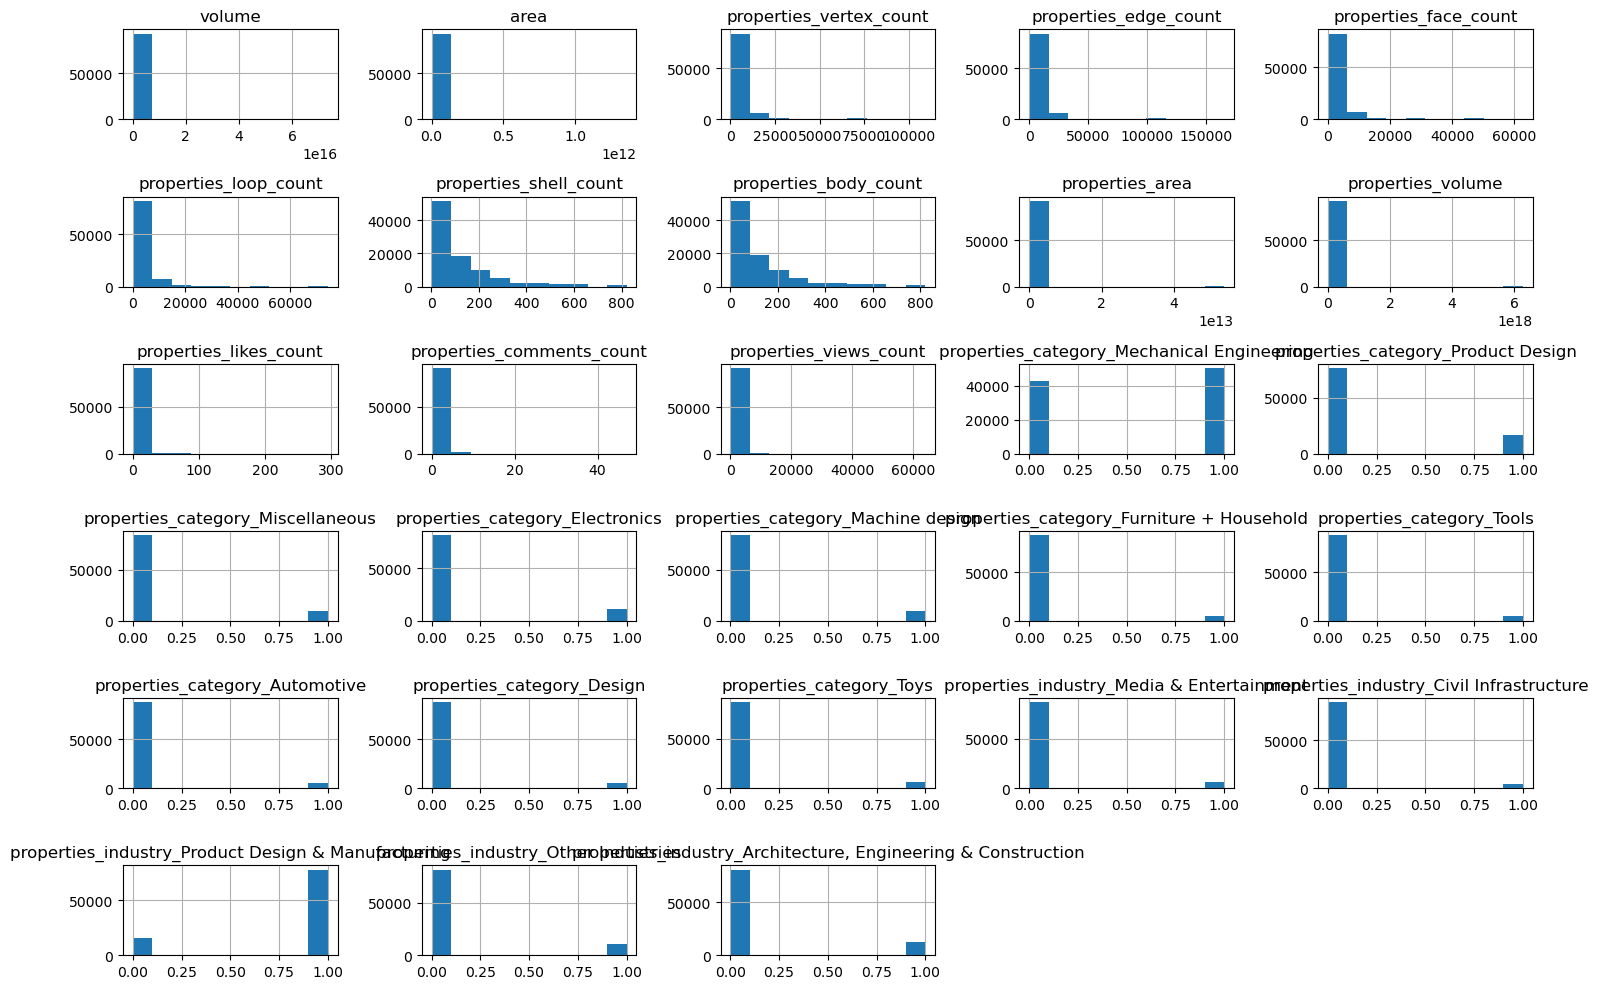

In [28]:
df_main.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

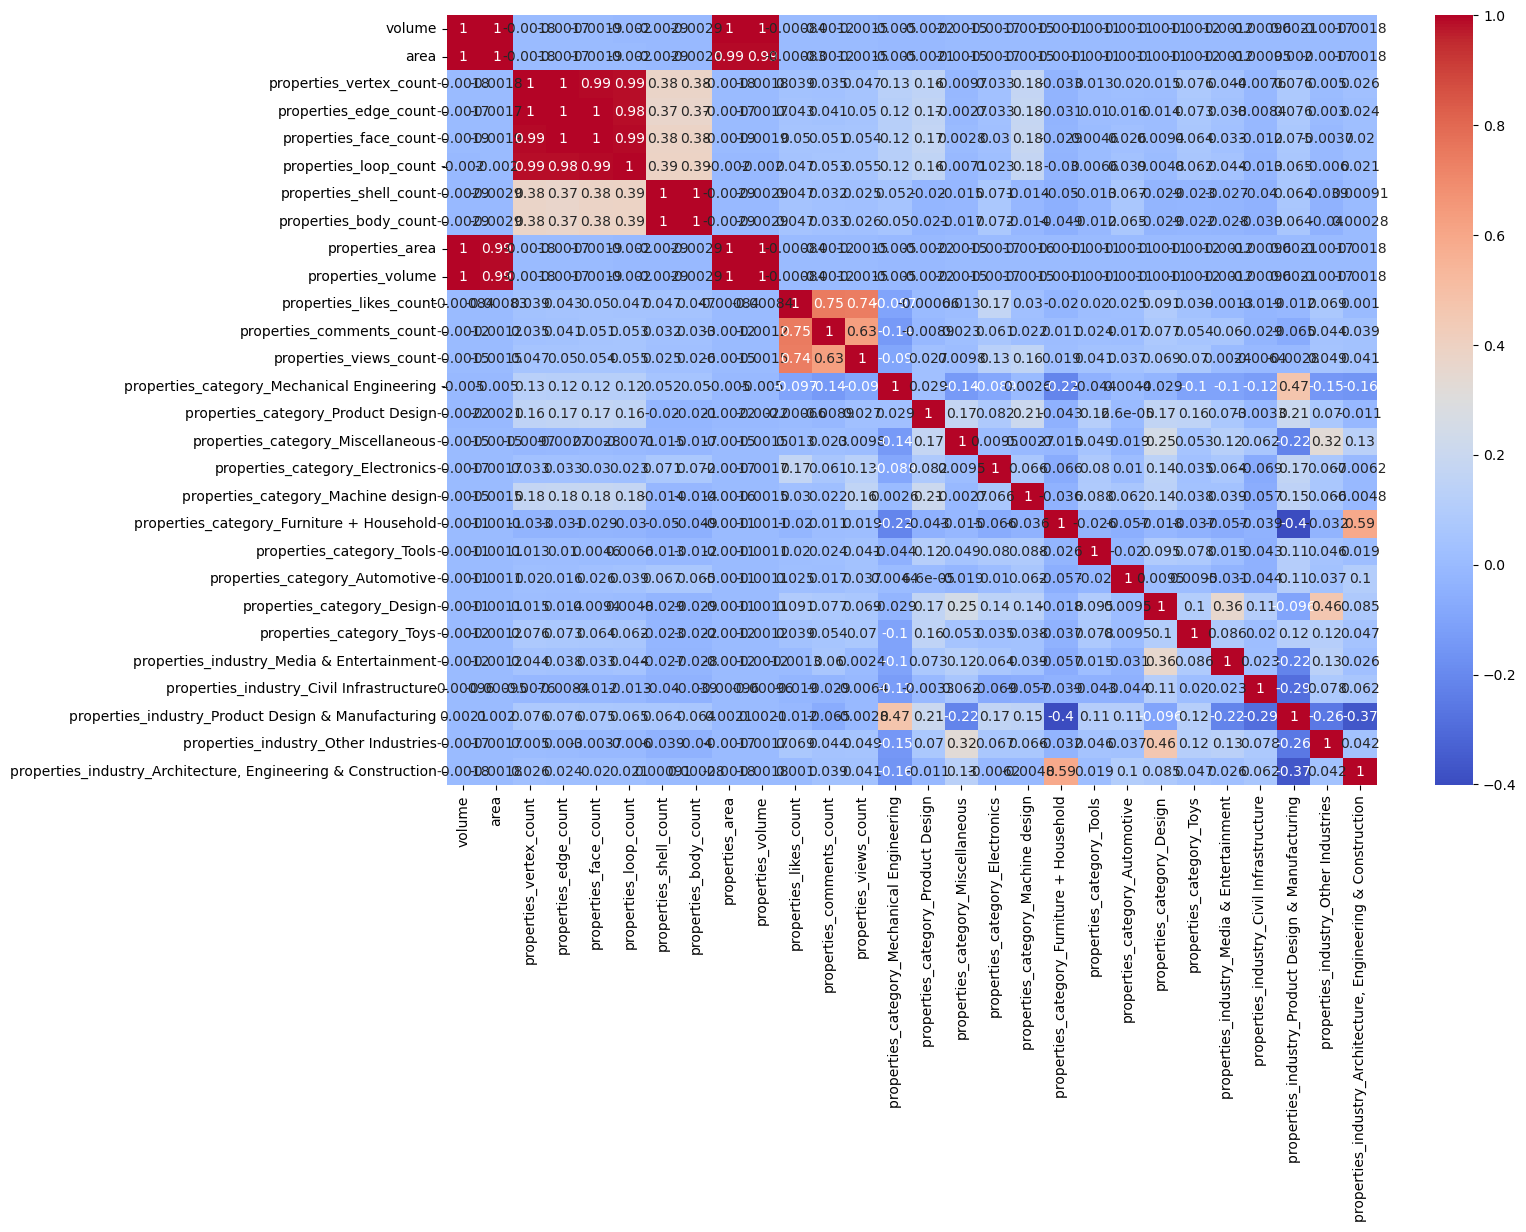

In [30]:
import seaborn as sns

plt.figure(figsize=(15,10))
sns.heatmap(df_main.corr(), annot=True, cmap='coolwarm')
plt.show()

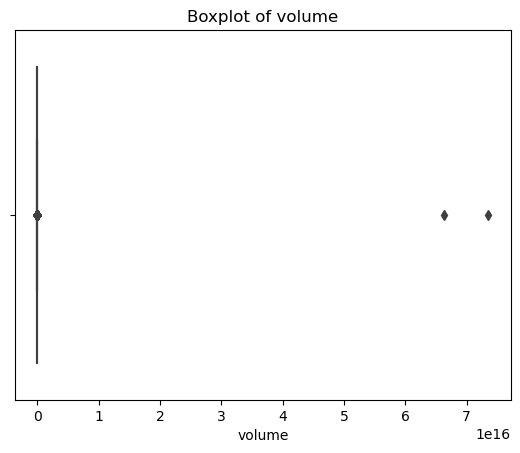

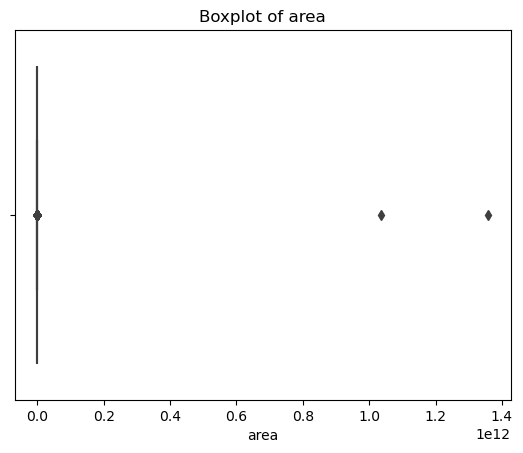

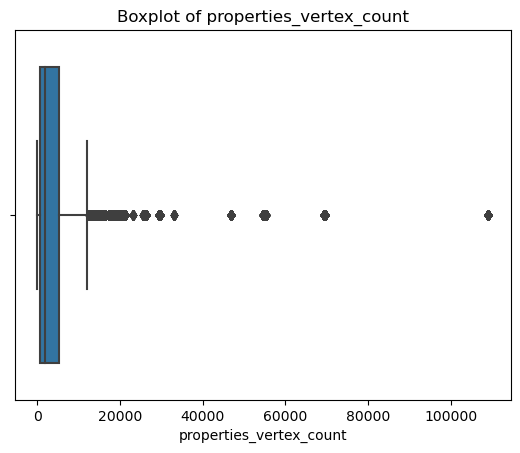

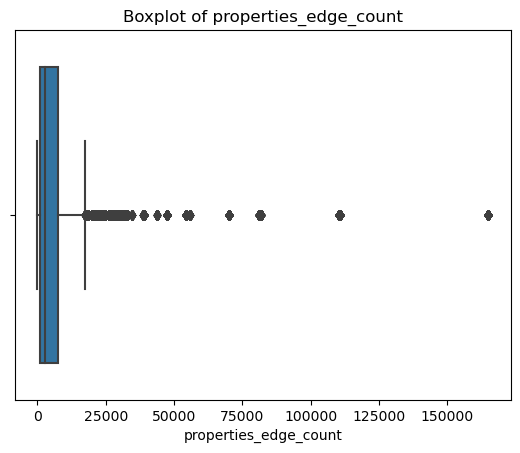

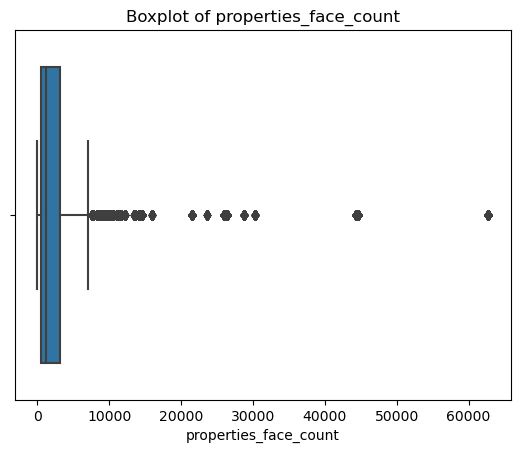

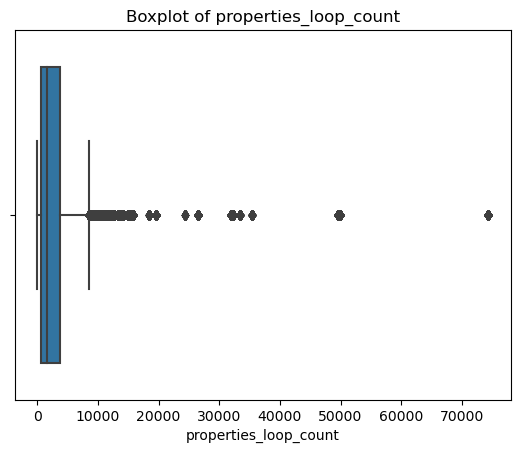

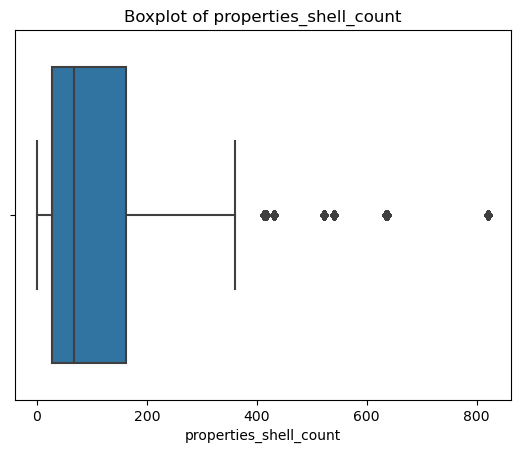

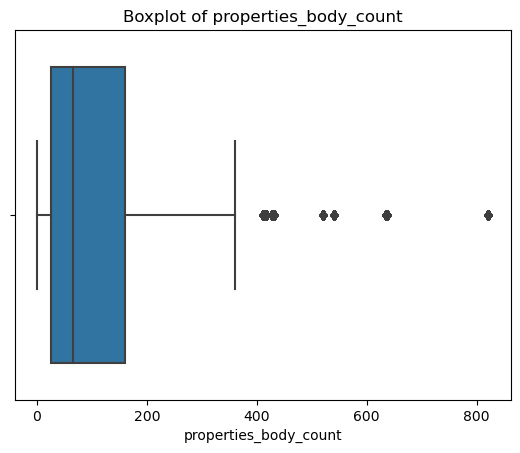

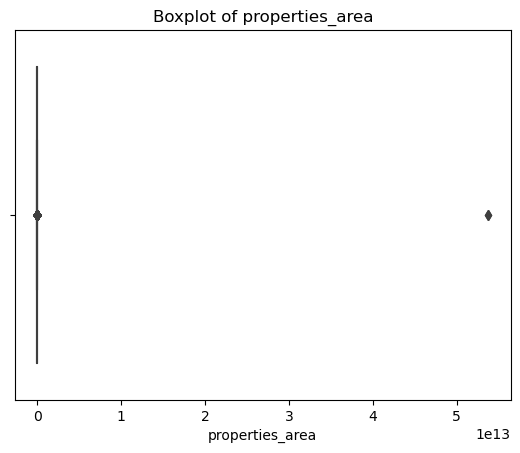

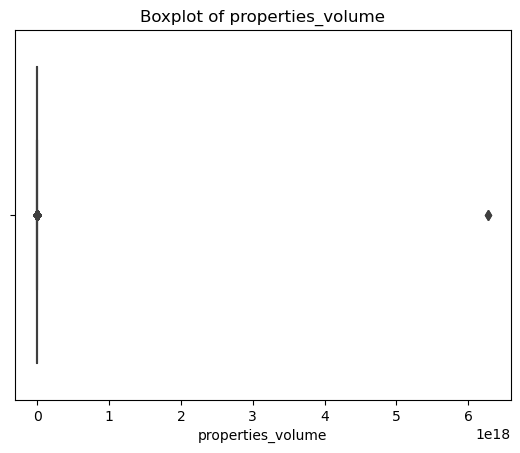

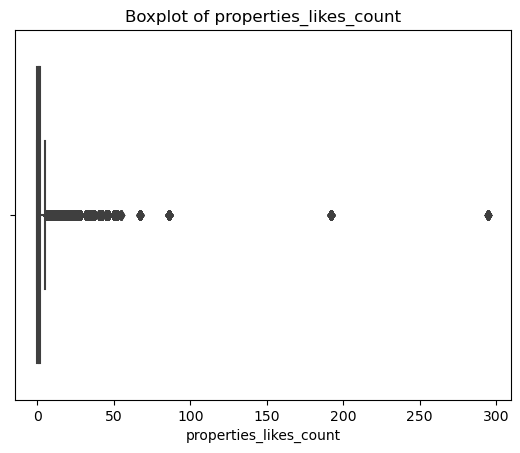

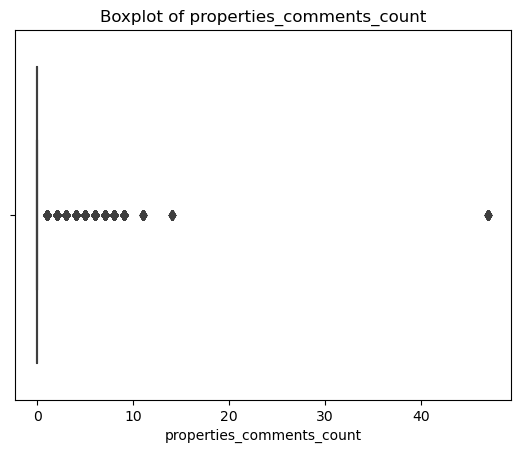

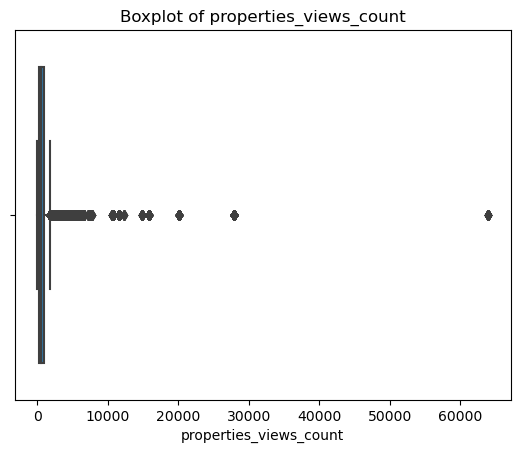

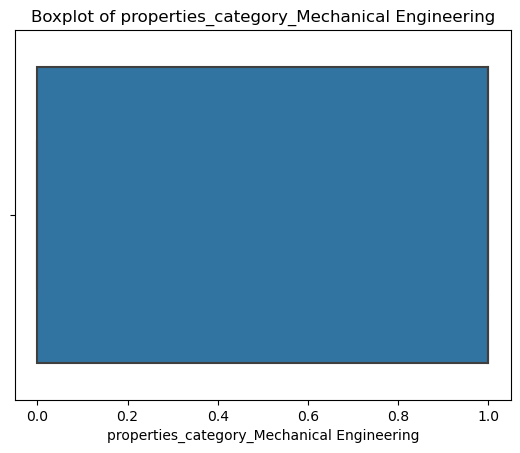

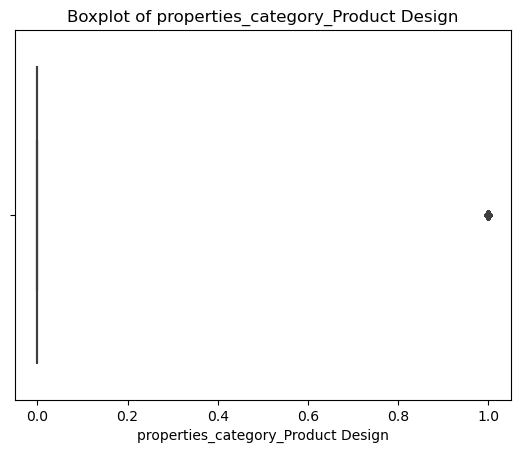

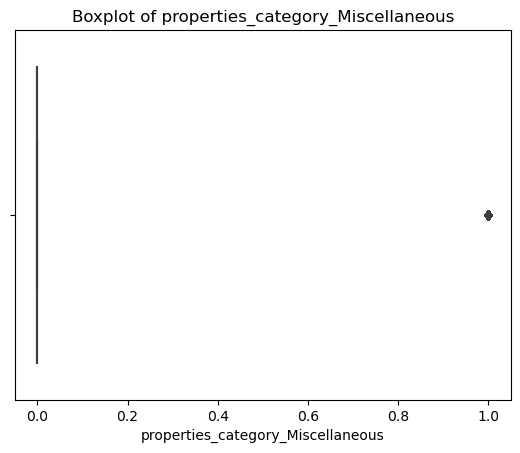

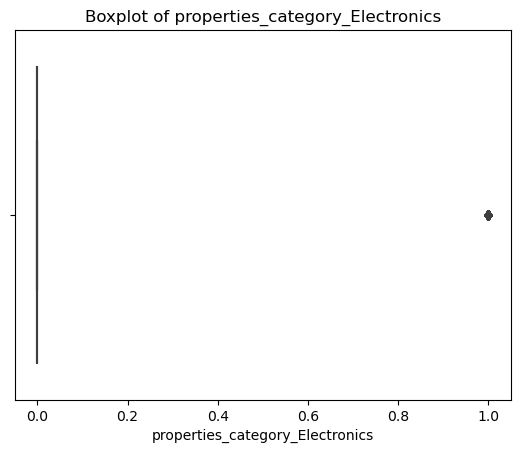

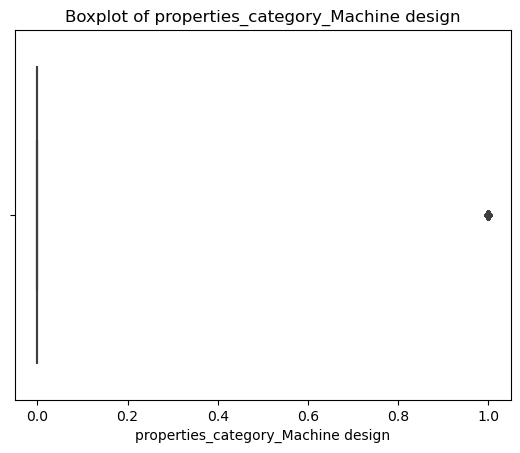

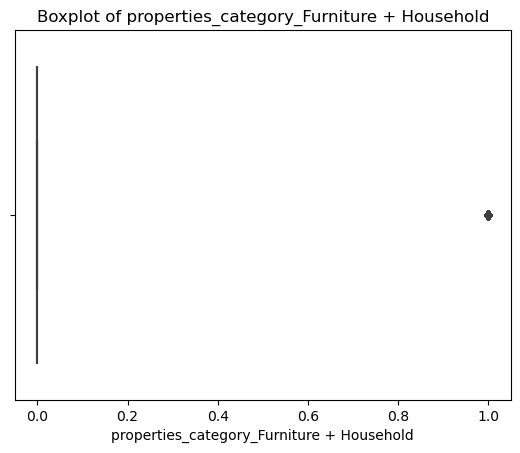

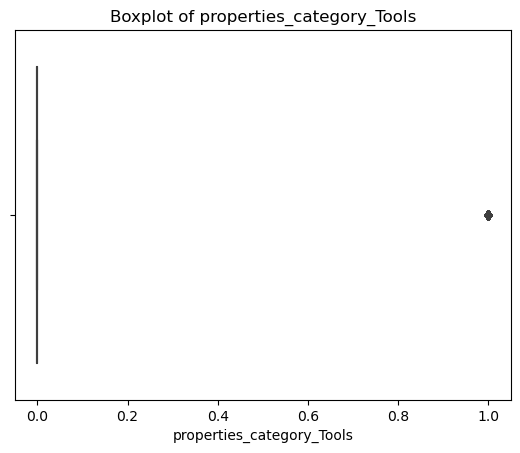

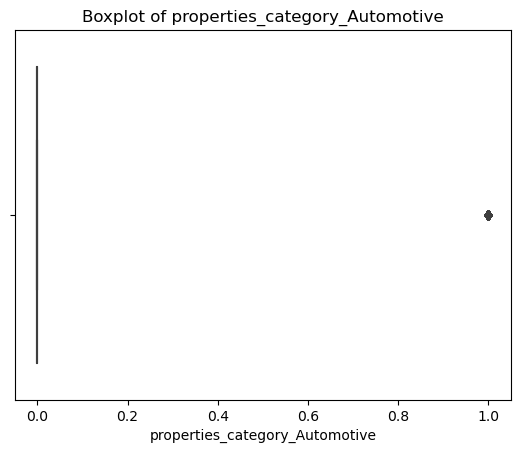

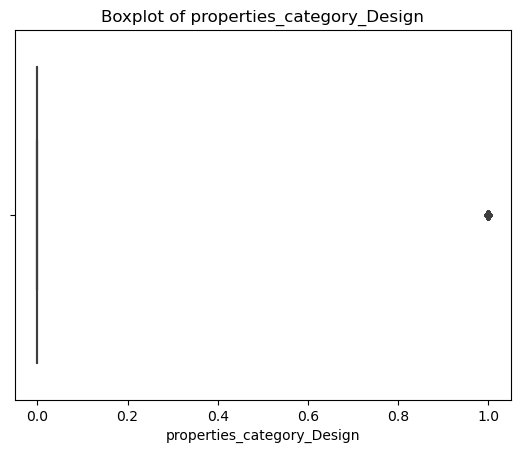

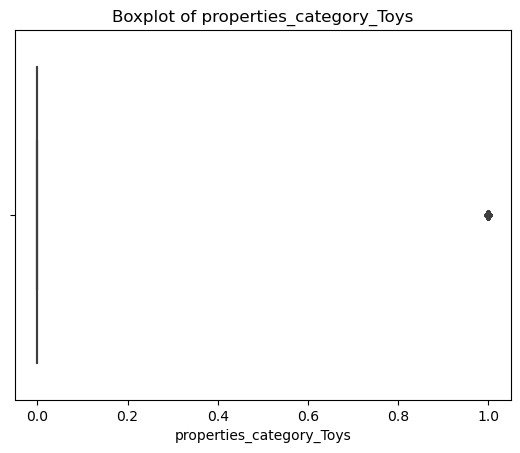

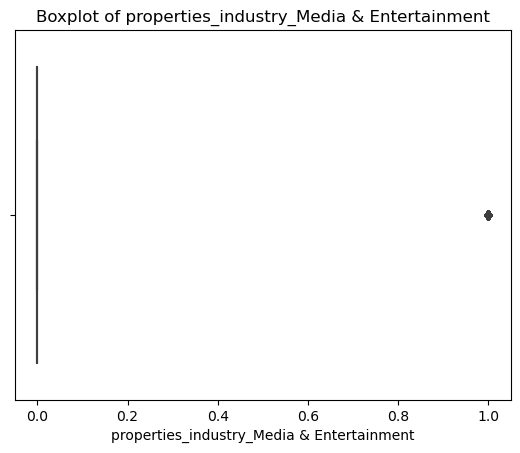

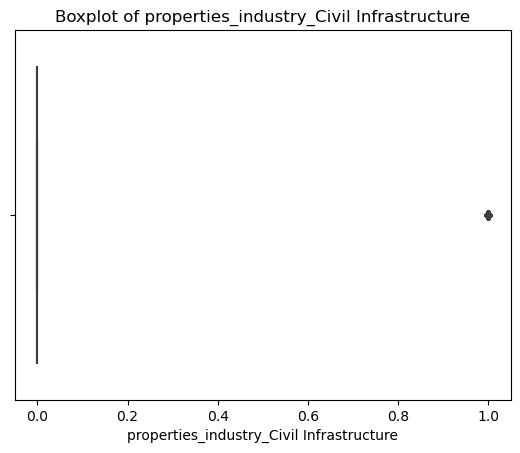

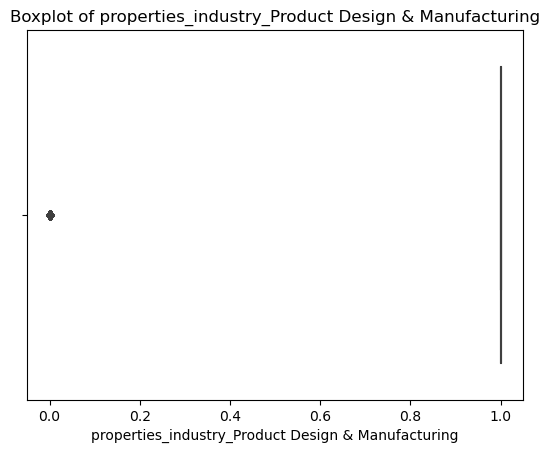

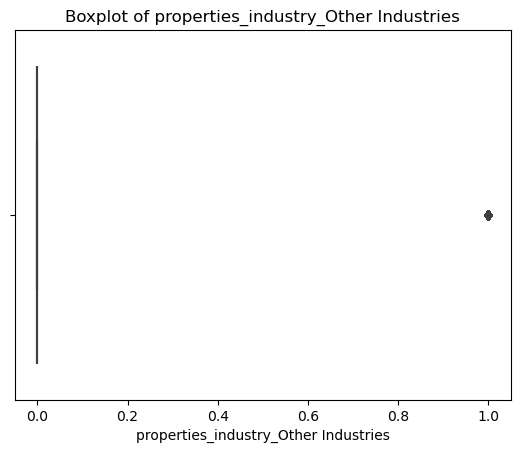

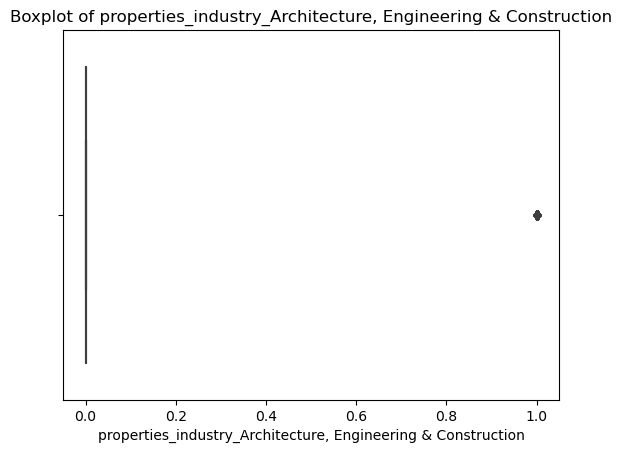

In [31]:
for col in df_main.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure()
    sns.boxplot(data=df_main, x=col)
    plt.title(f"Boxplot of {col}")
    plt.show()

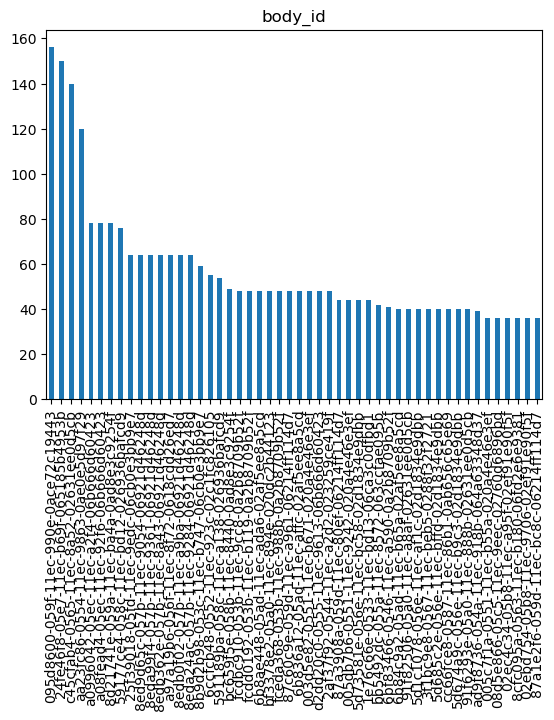

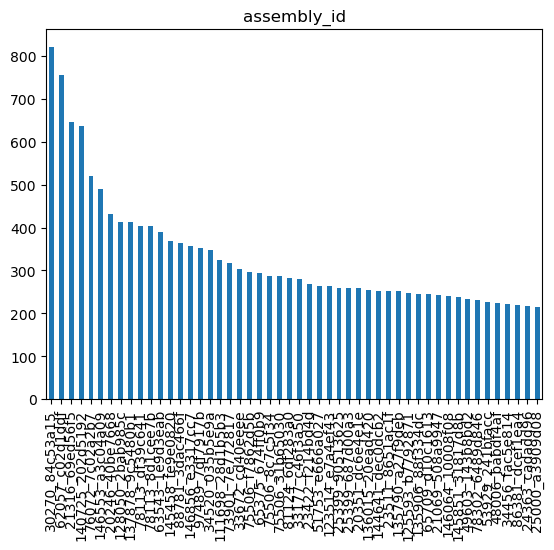

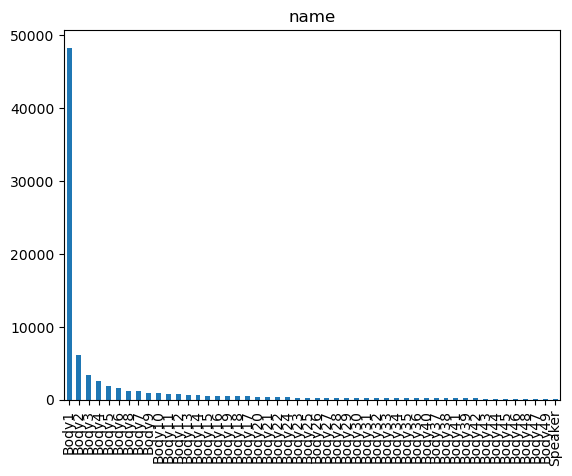

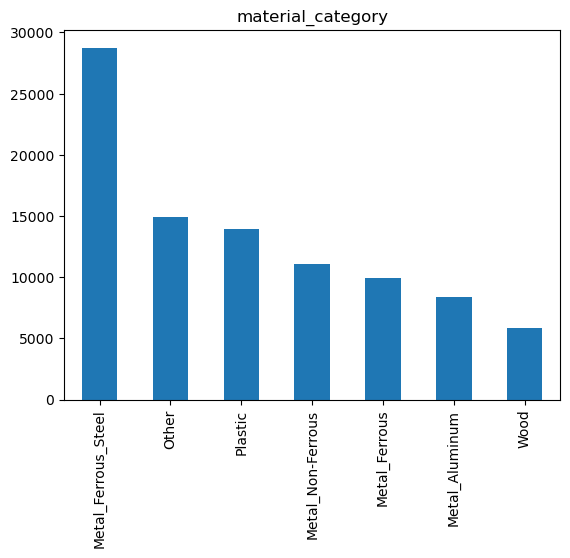

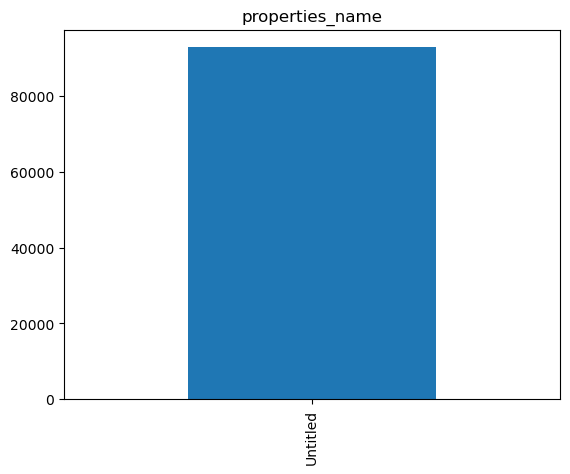

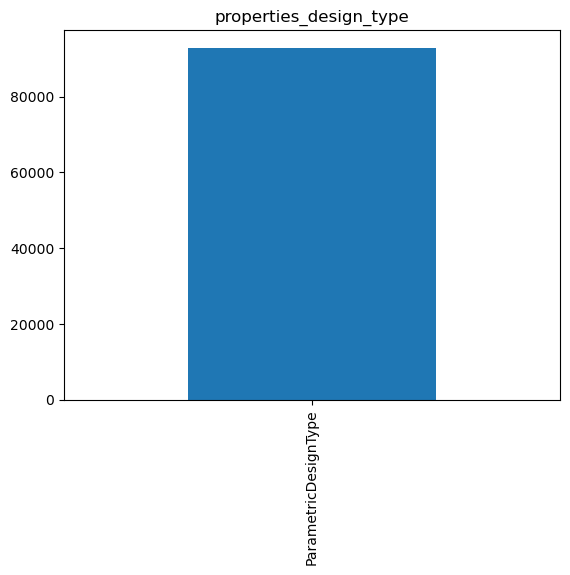

c:\Users\richt\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 35945 (\N{CJK UNIFIED IDEOGRAPH-8C69}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


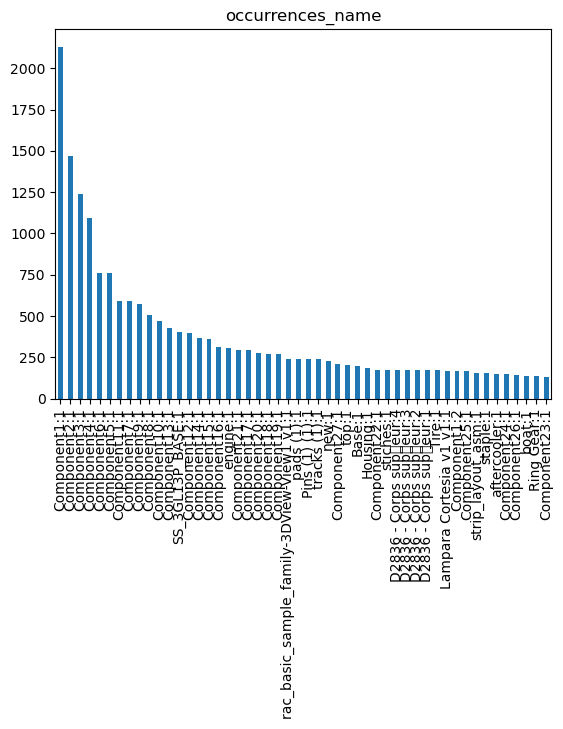

c:\Users\richt\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 35945 (\N{CJK UNIFIED IDEOGRAPH-8C69}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


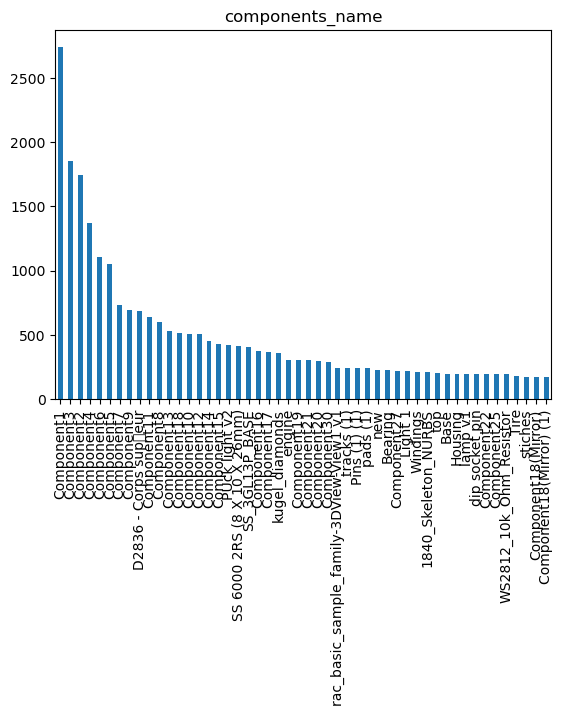

In [34]:
N = 50
for col in df_main.select_dtypes(include=['object']).columns:
    df_main[col].value_counts().head(N).plot(kind='bar', title=col)
    plt.show()


In [38]:
df_main = df_main.drop(columns=["properties_design_type", "properties_name"])

In [39]:
# Identify rows where the 'name' column matches the pattern and replace them with NaN
df_main.loc[df_main['name'].str.match('^Body\d+$', na=False), 'name'] = np.nan

NameError: name 'np' is not defined

In [ ]:
THRESHOLD = 1e8

# Filter out outliers based on area and volume columns
filtered_df = df_main[(df_main['area'] < THRESHOLD) &
                      (df_main['volume'] < THRESHOLD) &
                      (df_main['properties_area'] < THRESHOLD) &
                      (df_main['properties_volume'] < THRESHOLD)]

# Replace the main dataframe with the filtered one
df_main = filtered_df.copy()
